In [524]:
from zipfile import ZipFile
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from geopandas import GeoDataFrame
from descartes import PolygonPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [525]:
import pandas as pd
import zipfile
import re


# Loading incident data 
zf = zipfile.ZipFile('Data_incidents.csv.zip') 
df = pd.read_csv(zf.open('Data_incidents.csv.zip'))

df.head(1)

/Users/josefinebjornholm/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,...,Officer Involved Shooting - Bystander killed,Child injured,Gun buy back action,Terrorism Involvement,Officer Involved Shooting - Accidental discharge - no injury required,Mistaken ID,Officer Involved Shooting - subject/suspect/perpetrator suicide by cop,Ghost gun,Political Violence,NAV
0,0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,...,False,False,False,False,False,False,False,False,False,False


In [526]:
# Loading law data 
df_law = pd.read_csv('gun_law_merge.csv', sep = ';')

# Renaming the state column
df_law.rename(columns={'Unnamed: 0':'state'}, inplace=True)

In [527]:
# Loading map data 
usa = gpd.read_file('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/maps/states_21basic/states.shp')
usa.head(2)

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."


### Excluding Alaska and Hawaii

In [528]:
usa_49 = usa[1:50]

### Grouping the incident data by sum and count depending on what we want

In [529]:
df_group_count=df.groupby('state').count().reset_index()
df_group_incidents_count = df_group_count[['state','incident_id']]
df_group_sum = df.groupby('state').sum().reset_index()
df_group_incidents_sum = df_group_sum[['state','n_killed','n_injured']]
df_group_incidents_sum.head(1)

# Dataset with N_incident, n_killed and n_injured
df_group_incidents= df_group_incidents_sum.set_index('state').join(df_group_incidents_count.set_index('state')).reset_index()

### Grouping the incident data by number of true in incident characteristics

In [530]:
df_IC = df.iloc[:, [3] + list(range(30,139))]
df_IC_group = df_IC.groupby('state').sum().reset_index()

for col in df_IC_group.columns: 
    print(col)

state
Shot - Wounded/Injured
Mass Shooting
Possession
Possession of gun by felon or prohibited person
Shot - Dead
Gang involvement
Shots Fired - No Injuries
Bar/club incident - in or around establishment
Officer Involved Incident
Officer Involved Shooting - subject/suspect/perpetrator killed
Drug involvement
Kidnapping/abductions/hostage
Under the influence of alcohol or drugs
Suicide
Murder/Suicide
Attempted Murder/Suicide
Domestic Violence
Home Invasion
Home Invasion - Resident killed
Armed robbery with injury/death and/or evidence of DGU found
Drive-by
Officer Involved Shooting - Officer shot
Officer Involved Shooting - Officer killed
Officer Involved Shooting - subject/suspect/perpetrator shot
Officer Involved Shooting - subject/suspect/perpetrator suicide at standoff
Spree Shooting
Institution/Group/Business
Animal shot/killed
Home Invasion - Resident injured
Mass Murder
Concealed Carry License - Perpetrator
Stolen/Illegally owned
School Incident
School Shooting - university/colle

### Editing law data

In [531]:
laws =['State permit required to purchase? - Long guns',
'Firearm registration? - Long guns',
'Owner license required? - Long guns',
'Assault weapon law? - Long guns',
'NFA weapons restricted? - Long guns',
'Background checks required for private sales? - Long guns',
'Magazine Capacity Restriction? - Long guns',
'Red flag law? - Long guns',
'State permit required to purchase? - Handguns',
'Firearm registration? - Handguns',
'Owner license required? - Handguns',
'Assault weapon law? - Handguns',
'NFA weapons restricted? - Handguns',
'Background checks required for private sales? - Handguns',
'Magazine Capacity Restriction? - Handguns',
'Red flag law? - Handguns']

laws_longguns = laws[0:8]
laws_handguns = laws[8:16]

print(len(laws_longguns))
print(len(laws_handguns))


#count how many laws on handguns and longgund each state has

df_law['handgun_laws - count'] = df_law.loc[:, laws_handguns].sum(axis=1)
df_law['longgun_laws - count'] = df_law.loc[:, laws_longguns].sum(axis=1)
df_law.head(1)

8
8


,state,State permit required to purchase? - Long guns,Firearm registration? - Long guns,Owner license required? - Long guns,Assault weapon law? - Long guns,NFA weapons restricted? - Long guns,Background checks required for private sales? - Long guns,Magazine Capacity Restriction? - Long guns,Red flag law? - Long guns,State permit required to purchase? - Handguns,Firearm registration? - Handguns,Owner license required? - Handguns,Assault weapon law? - Handguns,NFA weapons restricted? - Handguns,Background checks required for private sales? - Handguns,Magazine Capacity Restriction? - Handguns,Red flag law? - Handguns,handgun_laws - count,longgun_laws - count
0,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Merging the map data, incident data and law data

In [532]:
merged_group = usa_49.set_index('STATE_NAME').join(df_group_incidents.set_index('state')).reset_index()
merged_group_all = merged_group.set_index('STATE_NAME').join(df_IC_group.set_index('state')).join(df_law.set_index('state'))

# Renaming incident_id to N_incident
merged_group_all.rename(columns={'incident_id':'N_incident'}, inplace=True)

In [533]:
merged_group_all['NFA weapons restricted? - Handguns']
merged_group_all[['N_incident','n_killed', 'n_injured','Child injured','Mass Shooting', 'Child killed self','Hate crime','NFA weapons restricted? - Handguns']].describe()

,N_incident,n_killed,n_injured,Child injured,Mass Shooting,Child killed self,Hate crime,NFA weapons restricted? - Handguns
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,46.000000
mean,4857.938776,1227.306122,2408.000000,21.102041,33.387755,3.326531,2.081633,0.217391
std,4274.192138,1254.442509,2565.497012,22.259123,40.229972,4.084461,2.970948,0.417029
min,472.000000,57.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1651.000000,282.000000,674.000000,4.000000,5.000000,0.000000,0.000000,0.000000
50%,3434.000000,853.000000,1415.000000,10.000000,17.000000,2.000000,1.000000,0.000000
75%,6631.000000,1705.000000,3566.000000,39.000000,47.000000,5.000000,2.000000,0.000000
max,17556.000000,5562.000000,13514.000000,83.000000,194.000000,19.000000,15.000000,1.000000


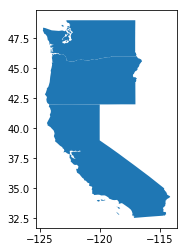

In [534]:
## Code for plotting specific regions (can also be used for states etc)
merged_group[merged_group.SUB_REGION == 'Pacific'].plot()

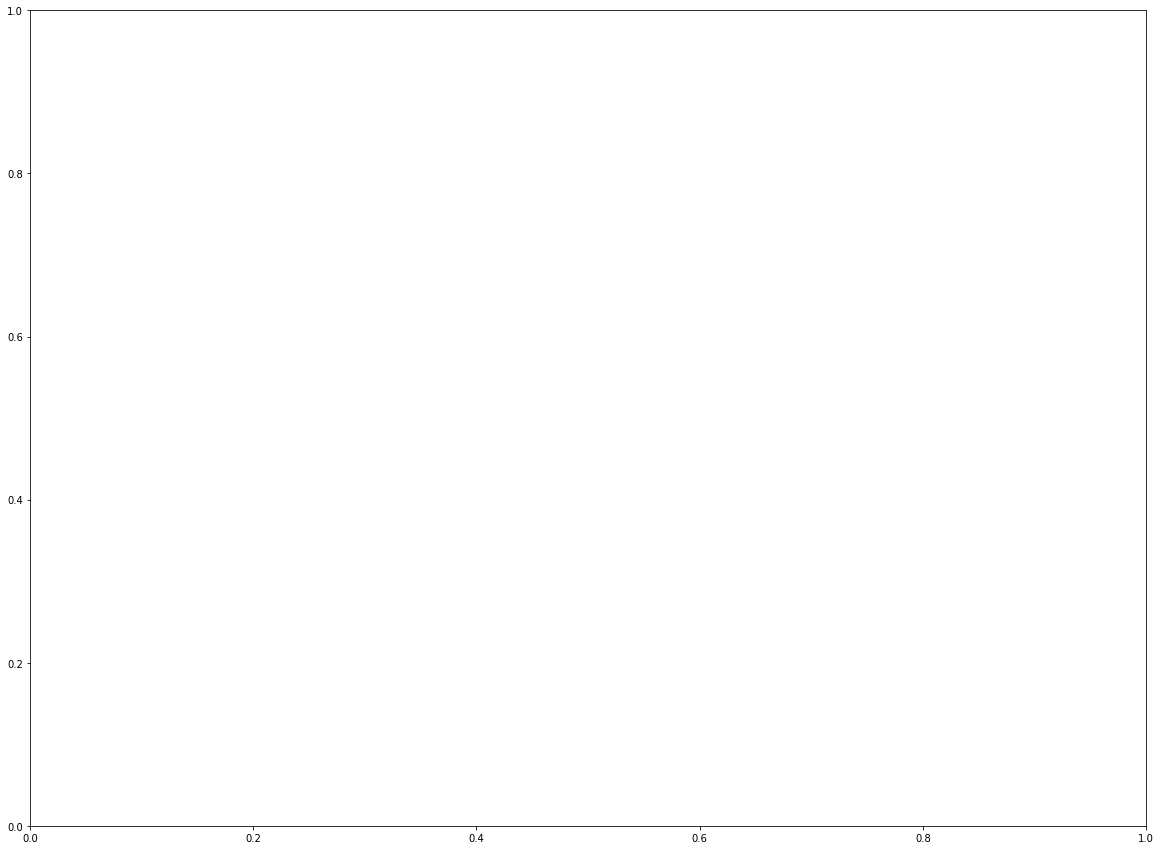

In [553]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Child injured'

# set the range for the choropleth
vmin, vmax = 0, 8

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 15))

In [554]:
merged_group_all.plot(column=variable, cmap='Reds', linewidth=0.8, ax = ax)

<Figure size 432x288 with 0 Axes>

In [555]:
ax.axis('off')

(-127.62094421524407, -64.08109635606795, 23.73560864957025, 50.59249807458268)

In [556]:
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.00)


# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig.colorbar(sm, cax=cax)

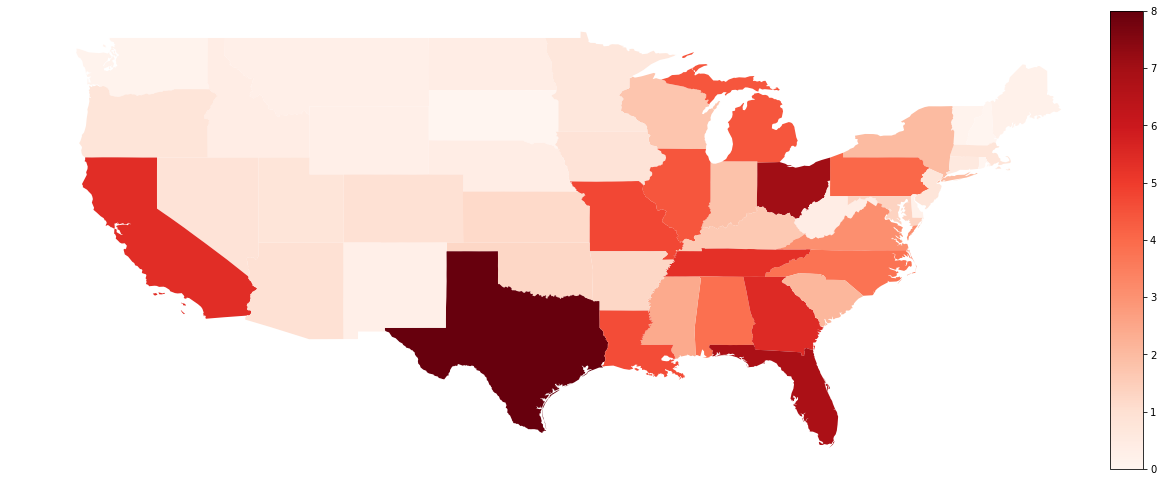

In [557]:
fig